In [ ]:
###Forecasting with machine learning

In [1]:
###Setup

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

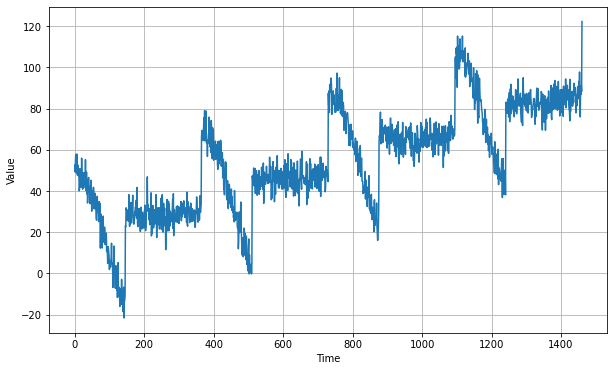

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
###Forecasting with Machine Learning

#First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
###Linear Model

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
    # take input window and computes a linear combination of the values in that window to produce one output
    keras.layers.Dense(1, input_shape=[window_size]) #1 dense layer with 1 neuron
])
optimizer = keras.optimizers.SGD(lr = 1e-5, momentum = 0.9) # optimizer is created; SGD=Stochastic gradient optimizer with learning rates of 1 to the minus 5
model.compile(loss = keras.losses.Huber(), #Huber is the type of loss
             optimizer = optimizer,
             metrics = ['mae'])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 3s 34ms/step - loss: 67.9541 - mae: 68.4529 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 13.7751 - mae: 14.2655 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 1s 10ms/step - loss: 10.6361 - mae: 11.1246 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 9.3667 - mae: 9.8515 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 9.4557 - mae: 9.9438 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 9.7406 - mae: 10.2282 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 9.4392 - mae: 9.9247 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 9ms/step - los

Epoch 63/100
31/31 [==============================] - 0s 10ms/step - loss: 5.9591 - mae: 6.4387 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/100
31/31 [==============================] - 1s 10ms/step - loss: 5.6997 - mae: 6.1804 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/100
31/31 [==============================] - 1s 11ms/step - loss: 5.4944 - mae: 5.9727 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/100
31/31 [==============================] - 1s 12ms/step - loss: 5.7553 - mae: 6.2379 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/100
31/31 [==============================] - 0s 10ms/step - loss: 5.7447 - mae: 6.2284 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/100
31/31 [==============================] - 0s 10ms/step - loss: 5.7999 - mae: 6.2857 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/100
31/31 [==============================] - 0s 10ms/step - loss: 5.4400 - mae: 5.9162 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/100
31/31 [==============================] - 0s 11ms/step - 

In [12]:
keras.backend.clear_session()
#tf.random.seed(42)
#np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

#automating it in this way so that learning is repeated
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10 ** (epoch / 30)) #learning rate = 1e-6 & it increases gradually so that every 30 epochs, it's multiplied by 10 
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule]) #this time a callback is added

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 17.1541 - mae: 17.6448
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 12.5263 - mae: 13.0116
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 12.0514 - mae: 12.5382
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 12.3914 - mae: 12.8822
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 12.1032 - mae: 12.5900
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 11.8363 - mae: 12.3221
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 12.0898 - mae: 12.5761
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 11.9211 - mae: 12.4117
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 11.1851 - mae: 11.6730
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 10.8572 - mae: 11.3480
Epoch 11/100
31/31 [===================

31/31 [==============================] - 0s 3ms/step - loss: 84.6652 - mae: 85.1640
Epoch 87/100
31/31 [==============================] - 0s 3ms/step - loss: 38.8815 - mae: 39.3796
Epoch 88/100
31/31 [==============================] - 0s 3ms/step - loss: 70.2086 - mae: 70.7081
Epoch 89/100
31/31 [==============================] - 0s 3ms/step - loss: 35.7666 - mae: 36.2626
Epoch 90/100
31/31 [==============================] - 0s 3ms/step - loss: 53.6588 - mae: 54.1580
Epoch 91/100
31/31 [==============================] - 0s 3ms/step - loss: 60.4899 - mae: 60.9855
Epoch 92/100
31/31 [==============================] - 0s 2ms/step - loss: 45.0477 - mae: 45.5471
Epoch 93/100
31/31 [==============================] - 0s 2ms/step - loss: 52.2340 - mae: 52.7307
Epoch 94/100
31/31 [==============================] - 0s 3ms/step - loss: 52.0133 - mae: 52.5112
Epoch 95/100
31/31 [==============================] - 0s 3ms/step - loss: 55.1973 - mae: 55.6957
Epoch 96/100
31/31 [=======================

(1e-06, 0.001, 0.0, 20.0)

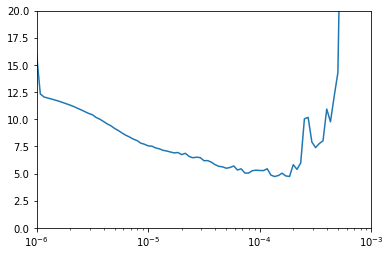

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping]) #another callback. Set patients = 10 so what this callback will do, is that it will check that the validation error keeps going down at every epoch.
#If it stops going down for 10 epochs, then the early stopping callback will interrupt training, so this ensures that when the model stops making progress, we stop training, or else, we run the risk of over-fitting the training set.
#If large number of epochs are run, that's okay because early stopping will usually stop training along before this high number of epochs is reached.
#We specify the callback here in the list of callbacks for the fit method, and training is run again.
#Traing stops if for some last (10) epochs, the validation error does not make a lot of progress. 

Epoch 1/500
31/31 [==============================] - 1s 15ms/step - loss: 67.9541 - mae: 68.4529 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 13.7751 - mae: 14.2655 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 10.6361 - mae: 11.1246 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 9.3667 - mae: 9.8515 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 9.4557 - mae: 9.9438 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 9ms/step - loss: 9.7406 - mae: 10.2282 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 9.4392 - mae: 9.9247 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 9ms/step - l

Epoch 63/500
31/31 [==============================] - 0s 8ms/step - loss: 5.9591 - mae: 6.4387 - val_loss: 5.8891 - val_mae: 6.3675
Epoch 64/500
31/31 [==============================] - 0s 8ms/step - loss: 5.6997 - mae: 6.1804 - val_loss: 5.7918 - val_mae: 6.2716
Epoch 65/500
31/31 [==============================] - 0s 8ms/step - loss: 5.4944 - mae: 5.9727 - val_loss: 5.7822 - val_mae: 6.2677
Epoch 66/500
31/31 [==============================] - 0s 8ms/step - loss: 5.7553 - mae: 6.2379 - val_loss: 5.8370 - val_mae: 6.3169
Epoch 67/500
31/31 [==============================] - 0s 8ms/step - loss: 5.7447 - mae: 6.2284 - val_loss: 5.8026 - val_mae: 6.2866
Epoch 68/500
31/31 [==============================] - 0s 8ms/step - loss: 5.7999 - mae: 6.2857 - val_loss: 5.8970 - val_mae: 6.3825
Epoch 69/500
31/31 [==============================] - 0s 8ms/step - loss: 5.4400 - mae: 5.9162 - val_loss: 6.1008 - val_mae: 6.5871
Epoch 70/500
31/31 [==============================] - 0s 8ms/step - loss: 5.

Epoch 125/500
31/31 [==============================] - 0s 9ms/step - loss: 4.7240 - mae: 5.1994 - val_loss: 5.0025 - val_mae: 5.4797
Epoch 126/500
31/31 [==============================] - 0s 9ms/step - loss: 4.8561 - mae: 5.3298 - val_loss: 4.9720 - val_mae: 5.4553
Epoch 127/500
31/31 [==============================] - 0s 10ms/step - loss: 4.8650 - mae: 5.3422 - val_loss: 4.9888 - val_mae: 5.4690
Epoch 128/500
31/31 [==============================] - 0s 10ms/step - loss: 4.5071 - mae: 4.9825 - val_loss: 4.8904 - val_mae: 5.3673
Epoch 129/500
31/31 [==============================] - 1s 12ms/step - loss: 4.5663 - mae: 5.0409 - val_loss: 4.9069 - val_mae: 5.3925
Epoch 130/500
31/31 [==============================] - 0s 11ms/step - loss: 4.5566 - mae: 5.0241 - val_loss: 4.9076 - val_mae: 5.3829
Epoch 131/500
31/31 [==============================] - 1s 12ms/step - loss: 4.6809 - mae: 5.1554 - val_loss: 4.9074 - val_mae: 5.3918
Epoch 132/500
31/31 [==============================] - 1s 11ms/s

31/31 [==============================] - 0s 8ms/step - loss: 4.3946 - mae: 4.8713 - val_loss: 4.9912 - val_mae: 5.4687
Epoch 187/500
31/31 [==============================] - 0s 8ms/step - loss: 4.5787 - mae: 5.0573 - val_loss: 4.8905 - val_mae: 5.3692
Epoch 188/500
31/31 [==============================] - 0s 8ms/step - loss: 4.3909 - mae: 4.8662 - val_loss: 4.5827 - val_mae: 5.0545
Epoch 189/500
31/31 [==============================] - 0s 8ms/step - loss: 4.6174 - mae: 5.0898 - val_loss: 4.7732 - val_mae: 5.2578
Epoch 190/500
31/31 [==============================] - 0s 8ms/step - loss: 4.3659 - mae: 4.8382 - val_loss: 4.8453 - val_mae: 5.3263
Epoch 191/500
31/31 [==============================] - 0s 8ms/step - loss: 4.4774 - mae: 4.9536 - val_loss: 4.6002 - val_mae: 5.0768
Epoch 192/500
31/31 [==============================] - 0s 8ms/step - loss: 4.4683 - mae: 4.9417 - val_loss: 4.7555 - val_mae: 5.2396
Epoch 193/500
31/31 [==============================] - 0s 8ms/step - loss: 4.2842 -

In [16]:
def model_forecast(model, series, window_size): 
#run our model to make predictions.
#A function is created which takes the model, a portion of the time series & the window size,
#then it just creates a TF dataset much like earlier except no labels because we're trying to make predictions
#we just call model_predict on the dataset that we create
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds) #these will be the forecasts
    return forecast

In [18]:
#run the function, model_forecast, giving it the model and giving a potion of the time series
#make predictions on the validation set
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]
#a 2D tensor is returned, second dimension is of size one because the model makes one prediction per step

In [19]:
lin_forecast.shape

(461,)

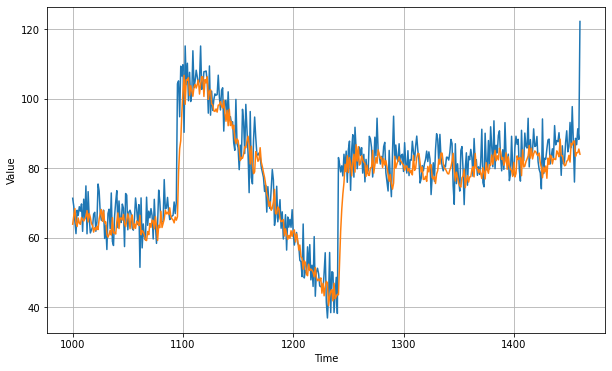

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [21]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

5.1662674

In [ ]:
###Dense Model Forecasting

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]), #2 hidden layers with 10 neurons each 
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1) #1 outer layer
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 43.3616 - mae: 43.8601
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 42.0590 - mae: 42.5571
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 38.8041 - mae: 39.3038
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 36.2801 - mae: 36.7800
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 31.8383 - mae: 32.3377
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 28.2799 - mae: 28.7788
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 23.7496 - mae: 24.2475
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 18.6970 - mae: 19.1927
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 13.6306 - mae: 14.1227
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 9.2946 - mae: 9.7853
Epoch 11/100
31/31 [=====================

31/31 [==============================] - 0s 3ms/step - loss: 12.8144 - mae: 13.3055 0s - loss: 9.2228 - mae: 9.711
Epoch 87/100
31/31 [==============================] - 0s 3ms/step - loss: 32.1009 - mae: 32.5981
Epoch 88/100
31/31 [==============================] - 0s 3ms/step - loss: 42.0675 - mae: 42.5665
Epoch 89/100
31/31 [==============================] - 0s 3ms/step - loss: 41.4813 - mae: 41.9790
Epoch 90/100
31/31 [==============================] - 0s 3ms/step - loss: 39.9546 - mae: 40.4533
Epoch 91/100
31/31 [==============================] - 0s 3ms/step - loss: 39.4200 - mae: 39.9168
Epoch 92/100
31/31 [==============================] - 0s 2ms/step - loss: 37.2988 - mae: 37.7957
Epoch 93/100
31/31 [==============================] - 0s 2ms/step - loss: 36.8191 - mae: 37.3170
Epoch 94/100
31/31 [==============================] - 0s 3ms/step - loss: 36.6483 - mae: 37.1469
Epoch 95/100
31/31 [==============================] - 0s 3ms/step - loss: 34.8885 - mae: 35.3828
Epoch 96/100

(1e-07, 0.005, 0.0, 30.0)

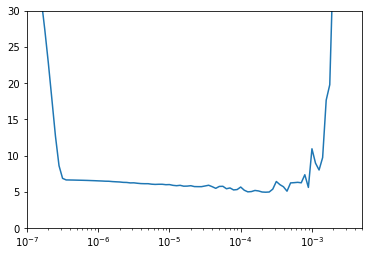

In [23]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [25]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]), #best learning rate is used so Learning Scheduler is used to keep it same
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 16ms/step - loss: 29.0004 - mae: 29.4979 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 9ms/step - loss: 9.2173 - mae: 9.7037 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 9ms/step - loss: 8.2229 - mae: 8.7084 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 7.5460 - mae: 8.0330 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 7.4025 - mae: 7.8870 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 1s 12ms/step - loss: 7.2160 - mae: 7.6998 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 1s 12ms/step - loss: 7.2283 - mae: 7.7119 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 10ms/step - loss: 6.

Epoch 63/500
31/31 [==============================] - 0s 8ms/step - loss: 5.5672 - mae: 6.0498 - val_loss: 5.0692 - val_mae: 5.5508
Epoch 64/500
31/31 [==============================] - 0s 8ms/step - loss: 5.3036 - mae: 5.7833 - val_loss: 5.2834 - val_mae: 5.7662
Epoch 65/500
31/31 [==============================] - 0s 8ms/step - loss: 5.2397 - mae: 5.7203 - val_loss: 5.0484 - val_mae: 5.5301
Epoch 66/500
31/31 [==============================] - 0s 8ms/step - loss: 5.3372 - mae: 5.8156 - val_loss: 5.1831 - val_mae: 5.6589
Epoch 67/500
31/31 [==============================] - 0s 8ms/step - loss: 5.1647 - mae: 5.6442 - val_loss: 5.0369 - val_mae: 5.5184
Epoch 68/500
31/31 [==============================] - ETA: 0s - loss: 5.3812 - mae: 5.859 - 0s 8ms/step - loss: 5.3146 - mae: 5.7933 - val_loss: 5.0227 - val_mae: 5.5027
Epoch 69/500
31/31 [==============================] - 0s 8ms/step - loss: 4.9064 - mae: 5.3864 - val_loss: 5.1051 - val_mae: 5.5804
Epoch 70/500
31/31 [==================

31/31 [==============================] - 0s 10ms/step - loss: 4.9841 - mae: 5.4640 - val_loss: 4.7665 - val_mae: 5.2440
Epoch 125/500
31/31 [==============================] - 0s 8ms/step - loss: 4.8867 - mae: 5.3651 - val_loss: 4.7709 - val_mae: 5.2495
Epoch 126/500
31/31 [==============================] - 0s 8ms/step - loss: 4.7661 - mae: 5.2401 - val_loss: 4.7648 - val_mae: 5.2428
Epoch 127/500
31/31 [==============================] - 0s 10ms/step - loss: 4.9773 - mae: 5.4503 - val_loss: 4.8925 - val_mae: 5.3660
Epoch 128/500
31/31 [==============================] - 0s 9ms/step - loss: 4.6171 - mae: 5.0934 - val_loss: 4.7861 - val_mae: 5.2643
Epoch 129/500
31/31 [==============================] - 0s 9ms/step - loss: 4.8433 - mae: 5.3217 - val_loss: 4.7655 - val_mae: 5.2437
Epoch 130/500
31/31 [==============================] - 0s 10ms/step - loss: 4.7806 - mae: 5.2596 - val_loss: 4.7819 - val_mae: 5.2601
Epoch 131/500
31/31 [==============================] - 0s 10ms/step - loss: 4.72

In [26]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

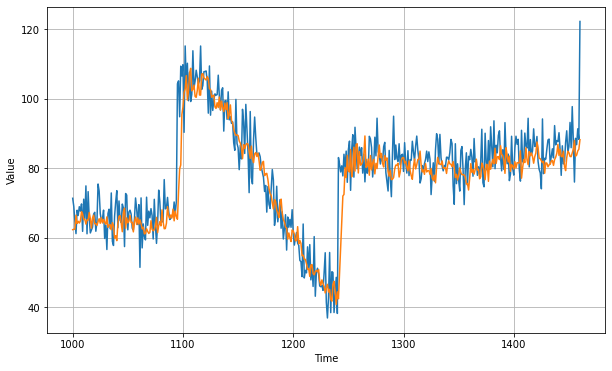

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [28]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.2025547